<a href="https://colab.research.google.com/github/Rigelabs/tensor_flow/blob/master/saving_loading_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Saving and Loading Models
In this tutorial we will learn how we can take a trained model, save it, and then load it back to keep training it or use it to perform inference. In particular, we will use transfer learning to train a classifier to classify images of cats and dogs, just like we did in the previous lesson. We will then take our trained model and save it as an HDF5 file, which is the format used by Keras. We will then load this model, use it to perform predictions, and then continue to train the model. Finally, we will save our trained model as a TensorFlow SavedModel and then we will download it to a local disk, so that it can later be used for deployment in different platforms.

In [3]:
!pip install -U tensorflow_hub
!pip install -U tensorflow_datasets

Requirement already up-to-date: tensorflow_hub in /usr/local/lib/python3.6/dist-packages (0.8.0)
     |████████████████████████████████| 3.4MB 3.5MB/s 
  Found existing installation: tensorflow-datasets 2.1.0
    Uninstalling tensorflow-datasets-2.1.0:
      Successfully uninstalled tensorflow-datasets-2.1.0


In [4]:
import time
import logging
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow.keras import layers

logging.getLogger('tensorflow').setLevel(logging.ERROR)
tfds.disable_progress_bar()

In [5]:
(train_examples,validation_examples), dataset_info = tfds.load(
    'cats_vs_dogs',split =['train[:80%]','train[80%:]'],as_supervised =True, 
    with_info = True
)

In [6]:
def format_image(image, label):
  # `hub` image modules exepct their data normalized to the [0,1] range.
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return  image, label

num_examples = dataset_info.splits['train'].num_examples

BATCH_SIZE = 32
IMAGE_RES = 224

train_batches      = train_examples.cache().shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.cache().map(format_image).batch(BATCH_SIZE).prefetch(1)

In [7]:
#Use TensorFlow Hub to do Transfer Learning.

URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

feature_extractor = hub.KerasLayer(URL, input_shape=(IMAGE_RES,IMAGE_RES,3))

#Freeze the variables in the feature extractor layer, so that the training only modifies the final classifier layer.
feature_extractor.trainable = False

In [8]:
# wrap the hub layer in a tf.keras.Sequential model, and add a new classification layer.
model = tf.keras.Sequential([feature_extractor,
                             layers.Dense(2)])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [9]:
#We now train this model like any other, by first calling compile followed by fit
model.compile(optimizer='adam',loss =tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics = ['accuracy'])
EPOCHS =10

history = model.fit(train_batches,epochs= EPOCHS,steps_per_epoch = BATCH_SIZE,validation_data=validation_batches)

Epoch 1/10
32/32 [==============================] - 15s 466ms/step - loss: 0.2088 - accuracy: 0.9355 - val_loss: 0.0779 - val_accuracy: 0.9766
Epoch 2/10
32/32 [==============================] - 12s 390ms/step - loss: 0.0647 - accuracy: 0.9805 - val_loss: 0.0555 - val_accuracy: 0.9832
Epoch 3/10
32/32 [==============================] - 12s 388ms/step - loss: 0.0510 - accuracy: 0.9854 - val_loss: 0.0472 - val_accuracy: 0.9845
Epoch 4/10
32/32 [==============================] - 12s 390ms/step - loss: 0.0502 - accuracy: 0.9863 - val_loss: 0.0489 - val_accuracy: 0.9843
Epoch 5/10
32/32 [==============================] - 12s 389ms/step - loss: 0.0598 - accuracy: 0.9824 - val_loss: 0.0400 - val_accuracy: 0.9856
Epoch 6/10
32/32 [==============================] - 12s 388ms/step - loss: 0.0379 - accuracy: 0.9863 - val_loss: 0.0400 - val_accuracy: 0.9867
Epoch 7/10
32/32 [==============================] - 13s 393ms/step - loss: 0.0621 - accuracy: 0.9785 - val_loss: 0.0543 - val_accuracy: 0.9811

In [10]:
#Check the classnames

class_names = np.array(dataset_info.features['label'].names)


#Run an image batch through the model and convert the indices to class names
image_batch , label_batch = next(iter(train_batches.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

#Predict image_batch against class_names
predicted_batch =model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
predicted_ids = np.argmax(predicted_batch,axis=-1)
predicted_class_names = class_names[predicted_ids]
predicted_class_names


array(['cat', 'cat', 'cat', 'dog', 'cat', 'cat', 'cat', 'cat', 'cat',
       'dog', 'dog', 'dog', 'dog', 'cat', 'dog', 'cat', 'cat', 'cat',
       'dog', 'dog', 'dog', 'cat', 'dog', 'dog', 'cat', 'cat', 'cat',
       'cat', 'dog', 'cat', 'dog', 'dog'], dtype='<U3')

In [11]:
print("Labels: ", label_batch)
print("Predicted labels: ", predicted_ids)

Labels:  [0 0 0 1 0 0 0 0 0 1 1 1 1 0 1 0 0 0 1 1 1 0 1 0 0 0 0 0 1 0 1 1]
Predicted labels:  [0 0 0 1 0 0 0 0 0 1 1 1 1 0 1 0 0 0 1 1 1 0 1 1 0 0 0 0 1 0 1 1]


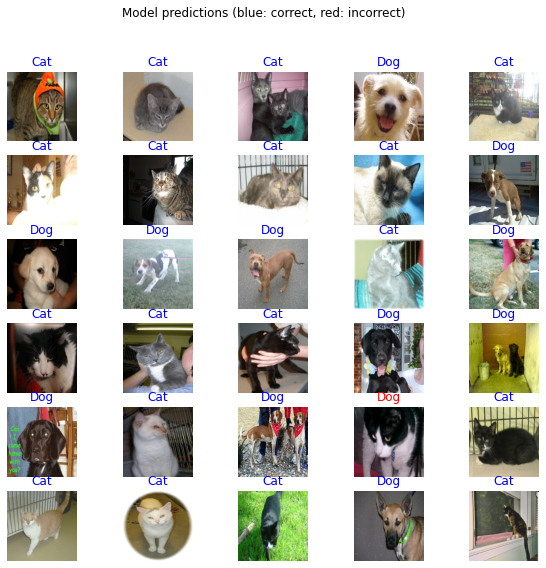

In [12]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")

#Save as Keras .h5 model
Now that we've trained the model, we can save it as an HDF5 file, which is the format used by Keras. Our HDF5 file will have the extension '.h5', and it's name will correpond to the current time stamp.

In [13]:
t =time.time()

export_path_keras = "./{}.h5".format(int(t))
print(export_path_keras)

model.save(export_path_keras)

./1596525930.h5


You can later recreate the same model from this file, even if you no longer have access to the code that created the model.

This file includes:

  1.The model's architecture

  2.The model's weight values (which were learned during training)

  3.The model's training config (what you passed to compile), if any
  
  4.The optimizer and its state, if any (this enables you to restart training where you left off)

# Load the Keras .h5 Model
We will now load the model we just saved into a new model called reloaded. We will need to provide the file path and the custom_objects parameter. This parameter tells keras how to load the hub.KerasLayer from the feature_extractor we used for transfer learning.

In [14]:
reloaded = tf.keras.models.load_model(export_path_keras,
                                     # `custom_objects` tells keras how to load a `hub.KerasLayer`
                                     custom_objects={'KerasLayer': hub.KerasLayer})

reloaded.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [15]:
#We can check that the reloaded model and the previous model give the same result

result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

(abs(result_batch -reloaded_result_batch)).max()

#As we can see, the reult is 0.0, which indicates that both models made the same predictions on the same batch of images.

0.0

# Keep Training
Besides making predictions, we can also take our reloaded model and keep training it. To do this, you can just train the reloaded as usual, using the .fit method.

In [16]:
EPOCHS = 10
history = reloaded.fit(train_batches,
                    epochs=EPOCHS, steps_per_epoch =32,
                    validation_data=validation_batches)

Epoch 1/10
32/32 [==============================] - 13s 408ms/step - loss: 0.0405 - accuracy: 0.4961 - val_loss: 0.0359 - val_accuracy: 0.4854
Epoch 2/10
32/32 [==============================] - 13s 396ms/step - loss: 0.0395 - accuracy: 0.4883 - val_loss: 0.0336 - val_accuracy: 0.4877
Epoch 3/10
32/32 [==============================] - 12s 389ms/step - loss: 0.0195 - accuracy: 0.4775 - val_loss: 0.0349 - val_accuracy: 0.4845
Epoch 4/10
32/32 [==============================] - 12s 390ms/step - loss: 0.0325 - accuracy: 0.4951 - val_loss: 0.0350 - val_accuracy: 0.4927
Epoch 5/10
32/32 [==============================] - 12s 390ms/step - loss: 0.0315 - accuracy: 0.4746 - val_loss: 0.0331 - val_accuracy: 0.4912
Epoch 6/10
32/32 [==============================] - 12s 389ms/step - loss: 0.0419 - accuracy: 0.5098 - val_loss: 0.0334 - val_accuracy: 0.4929
Epoch 7/10
32/32 [==============================] - 12s 390ms/step - loss: 0.0281 - accuracy: 0.5293 - val_loss: 0.0353 - val_accuracy: 0.4826

#Export as SavedModel
You can also export a whole model to the TensorFlow SavedModel format. SavedModel is a standalone serialization format for Tensorflow objects, supported by TensorFlow serving as well as TensorFlow implementations other than Python. A SavedModel contains a complete TensorFlow program, including weights and computation. It does not require the original model building code to run, which makes it useful for sharing or deploying (with TFLite, TensorFlow.js, TensorFlow Serving, or TFHub).

The SavedModel files that were created contain:

>1. A TensorFlow checkpoint containing the model weights.

> 2. A SavedModel proto containing the underlying Tensorflow graph. Separate graphs are saved for prediction (serving), train, and evaluation. If the model wasn't compiled before, then only the inference graph gets exported.
> 3. The model's architecture config, if available.

Let's save our original model as a TensorFlow SavedModel. To do this we will use the tf.saved_model.save() function. This functions takes in the model we want to save and the path to the folder where we want to save our model.

This function will create a folder where you will find an assets folder, a variables folder, and the saved_model.pb file.

In [17]:
t = time.time()

export_path_sm = "./{}".format(int(t))
print(export_path_sm)

tf.saved_model.save(model, export_path_sm)

!ls {export_path_sm}

./1596526421
assets	saved_model.pb	variables


# Load SavedModel
Now, let's load our SavedModel and use it to make predictions. We use the tf.saved_model.load() function to load our SavedModels. The object returned by tf.saved_model.load is 100% independent of the code that created it.

In [18]:
reloaded_sm = tf.saved_model.load(export_path_sm)

#Loading the SavedModel as a Keras Model

The object returned by tf.saved_model.load is not a Keras object (i.e. doesn't have .fit, .predict, .summary, etc. methods). Therefore, you can't simply take your reloaded_sm model and keep training it by running .fit. To be able to get back a full keras model from the Tensorflow SavedModel format we must use the tf.keras.models.load_model function. This function will work the same as before, except now we pass the path to the folder containing our SavedModel.

In [19]:
t = time.time()

export_path_sm = "./{}".format(int(t))
print(export_path_sm)
tf.saved_model.save(model, export_path_sm)


reload_sm_keras = tf.keras.models.load_model(
  export_path_sm,
  custom_objects={'KerasLayer': hub.KerasLayer})

reload_sm_keras.summary()

./1596526874
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,226,434
Non-trainable params: 34,112
_________________________________________________________________


In [20]:
#Now, let's use the reloaded_sm)keras (reloaded Keras model from our SavedModel) to make predictions on a batch of images.
result_batch = model.predict(image_batch)
reload_sm_keras_result_batch = reload_sm_keras.predict(image_batch)

(abs(result_batch - reload_sm_keras_result_batch)).max()

0.0

You can download the SavedModel to your local disk by creating a zip file. We wil use the `-r` (recursice) option to zip all subfolders. 

In [21]:
!zip -r model.zip {export_path_sm}

  adding: 1596526874/ (stored 0%)
  adding: 1596526874/saved_model.pb (deflated 92%)
  adding: 1596526874/assets/ (stored 0%)
  adding: 1596526874/variables/ (stored 0%)
  adding: 1596526874/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: 1596526874/variables/variables.index (deflated 78%)


In [22]:
#Once the file is zipped, you can download it to your local disk.

try:
  from google.colab import files
  files.download('./model.zip')
except ImportError:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>